# Forecasting Cancellations

---


---

# Imports

In [1]:
from datetime import timedelta
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Bidirectional, Conv1D, Dense
from tensorflow.keras.layers import Dropout, Input, LSTM, MaxPooling1D, GRU

In [2]:
## Reading data and setting DT index
path = '../../data/3.3_data_exploded.feather'
data = pd.read_feather(path)
data = data.sort_values('Stay Date')
data = data.set_index('Stay Date')
data

,IsCanceled,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,...,ArrivalDate_DaysBeforeHoliday,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalWeek,ArrivalDay,ArrivalDateDayName,ArrivalDateMonthName
Stay Date,,,,,,,,,,,,,,,,,,,,,
2015-07-01,0,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,...,45,21,43,23,51,15,27,3,Wednesday,July
2015-07-01,0,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,...,45,21,43,23,52,63,27,3,Wednesday,July
2015-07-01,0,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,...,45,21,43,23,52,63,27,3,Wednesday,July
2015-07-01,0,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,...,45,21,43,23,52,63,27,3,Wednesday,July
2015-07-01,0,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,...,45,21,43,23,52,63,27,3,Wednesday,July
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-11,0,2,0.0,0,BB,IRL,Direct,Direct,0,0,...,37,14,23,28,67,36,35,2,Tuesday,August
2017-09-12,0,2,0.0,0,HB,DEU,Offline TA/TO,TA/TO,0,0,...,35,16,21,30,22,81,35,4,Thursday,August
2017-09-12,0,2,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,...,35,16,21,30,72,31,35,4,Thursday,August


In [3]:
data['ReservationStatus'].value_counts()

ReservationStatus
Check-Out    255040
Canceled     149740
No-Show        4477
Name: count, dtype: int64

In [4]:
data.loc[:, 'ReservationStatus'] = np.where(data['ReservationStatus'] == 'No-Show', 'Canceled', data['ReservationStatus'])
data.loc[:, 'ReservationStatus']

Stay Date
2015-07-01    Check-Out
2015-07-01    Check-Out
2015-07-01    Check-Out
2015-07-01    Check-Out
2015-07-01    Check-Out
                ...    
2017-09-11    Check-Out
2017-09-12    Check-Out
2017-09-12    Check-Out
2017-09-13    Check-Out
2017-09-13    Check-Out
Name: ReservationStatus, Length: 409257, dtype: object

In [5]:
data['ReservationStatus'].value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.62
Canceled     0.38
Name: proportion, dtype: float64

In [6]:
res_statuses = pd.DataFrame(data['ReservationStatus'])
res_statuses

,ReservationStatus
Stay Date,
2015-07-01,Check-Out
2015-07-01,Check-Out
2015-07-01,Check-Out
2015-07-01,Check-Out
2015-07-01,Check-Out
...,...
2017-09-11,Check-Out
2017-09-12,Check-Out
2017-09-12,Check-Out


In [7]:
## Group by date and reservation status
result = res_statuses.groupby(res_statuses.index).value_counts()
result_unstacked = result.unstack(fill_value=0)
result_unstacked.columns.name = None
result_unstacked

,Canceled,Check-Out
Stay Date,,
2015-07-01,19,101
2015-07-02,76,130
2015-07-03,85,94
2015-07-04,85,130
2015-07-05,77,134
...,...,...
2017-09-09,2,7
2017-09-10,2,3
2017-09-11,0,3


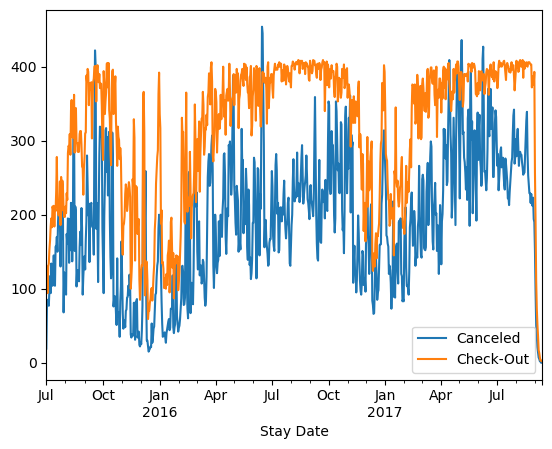

In [8]:
result_unstacked.plot();

# Resample to Set Frequency

In [9]:
result_unstacked

,Canceled,Check-Out
Stay Date,,
2015-07-01,19,101
2015-07-02,76,130
2015-07-03,85,94
2015-07-04,85,130
2015-07-05,77,134
...,...,...
2017-09-09,2,7
2017-09-10,2,3
2017-09-11,0,3


In [10]:
freq = 'D'
# freq = 'W'

data = result_unstacked.resample(freq).sum()
data

,Canceled,Check-Out
Stay Date,,
2015-07-01,19,101
2015-07-02,76,130
2015-07-03,85,94
2015-07-04,85,130
2015-07-05,77,134
...,...,...
2017-09-09,2,7
2017-09-10,2,3
2017-09-11,0,3


In [11]:
## Remove last 14 days to improve predictive quality
data = data.iloc[:-14]
data

,Canceled,Check-Out
Stay Date,,
2015-07-01,19,101
2015-07-02,76,130
2015-07-03,85,94
2015-07-04,85,130
2015-07-05,77,134
...,...,...
2017-08-26,228,403
2017-08-27,215,372
2017-08-28,212,387


# Create Holiday Features

In [12]:
# Generate a list of holidays for Portugal
us_holidays = holidays.Portugal(years=range(data.index.min().year, data.index.max().year + 1))

# Create a binary column for holidays
data['is_holiday'] = data.index.to_series().apply(lambda x: 1 if x in us_holidays else 0)

data

C:\Users\Ben\AppData\Local\Temp\ipykernel_19820\37905992.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_holiday'] = data.index.to_series().apply(lambda x: 1 if x in us_holidays else 0)


,Canceled,Check-Out,is_holiday
Stay Date,,,
2015-07-01,19,101,0
2015-07-02,76,130,0
2015-07-03,85,94,0
2015-07-04,85,130,0
2015-07-05,77,134,0
...,...,...,...
2017-08-26,228,403,0
2017-08-27,215,372,0
2017-08-28,212,387,0


In [13]:
us_holidays = holidays.Portugal(years=range(data.index.min().year, data.index.max().year + 1))

# Create binary columns for before_holiday and after_holiday
data['before_holiday'] = 0
data['after_holiday'] = 0

for date in data.index:
    # Check if the next day is a holiday
    if date + timedelta(days=1) in us_holidays:
        data.at[date, 'before_holiday'] = 1
    # Check if the previous day was a holiday
    if date - timedelta(days=1) in us_holidays:
        data.at[date, 'after_holiday'] = 1

# Display the DataFrame to verify
data.head()

C:\Users\Ben\AppData\Local\Temp\ipykernel_19820\1050289885.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['before_holiday'] = 0
C:\Users\Ben\AppData\Local\Temp\ipykernel_19820\1050289885.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['after_holiday'] = 0


,Canceled,Check-Out,is_holiday,before_holiday,after_holiday
Stay Date,,,,,
2015-07-01,19,101,0,0,0
2015-07-02,76,130,0,0,0
2015-07-03,85,94,0,0,0
2015-07-04,85,130,0,0,0
2015-07-05,77,134,0,0,0


# Transform Features

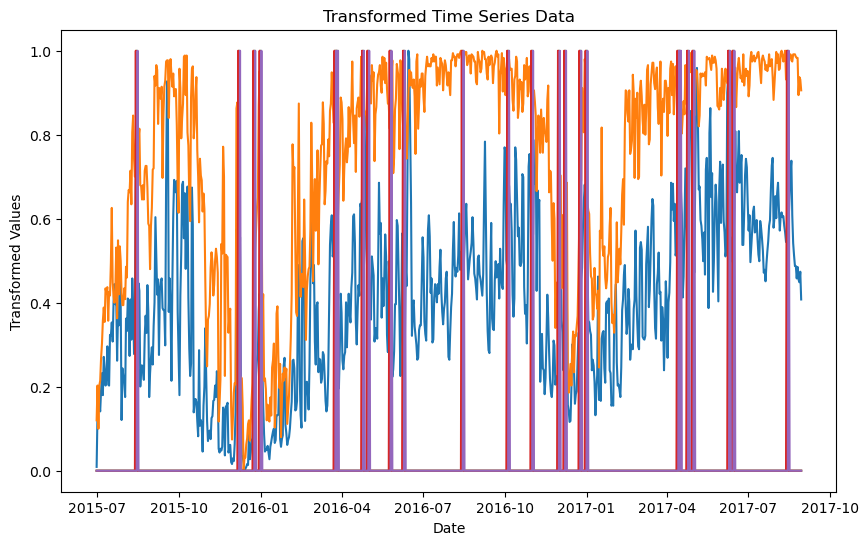

In [14]:
transformation_pipeline = MinMaxScaler(feature_range=(0, 1))

# transformation_pipeline = Pipeline([('power_transformer', PowerTransformer(method='yeo-johnson', standardize=True)),
#                                     ('scaler', MinMaxScaler(feature_range=(0, 1)))])

transformed_data = transformation_pipeline.fit_transform(data)

# Convert transformed data back to DataFrame for easier handling
transformed_df = pd.DataFrame(transformed_data, index=data.index)

# Plot the transformed time series data
plt.figure(figsize=(10, 6))
plt.plot(transformed_df)
plt.title('Transformed Time Series Data')
plt.xlabel('Date')
plt.ylabel('Transformed Values')
plt.show()


In [15]:
# Function to create sequences
def create_sequences(data, time_steps=1):
    """
    Create input sequences and corresponding labels for time series forecasting.

    Parameters:
    - data: numpy array
        The input data for creating sequences.
    - time_steps: int, optional
        The number of time steps to consider for each sequence. Default is 1.

    Returns:
    - X: numpy array
        The input sequences.
    - y: numpy array
        The corresponding labels.
    """
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, :])
    return np.array(X), np.array(y)

In [16]:
# Define time_steps
if freq == 'D':
    time_steps = 30
elif freq == 'W':
    time_steps = 12
elif freq == 'M':
    time_steps = 3
elif freq == 'Q':
    time_steps = 1
else:
    time_steps = 180

# Create sequences
X, y = create_sequences(transformed_data, time_steps)

# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Training data shape: {X_train.shape}, {y_train.shape}')
print(f'Test data shape: {X_test.shape}, {y_test.shape}')

y_shape = y.shape[1]

print(f'y_shape: {y_shape}')

Training data shape: (609, 30, 5), (609, 5)
Test data shape: (153, 30, 5), (153, 5)
y_shape: 5


In [39]:
# Define the LSTM model
model = Sequential()

model.add(Input(shape=(time_steps, X_train.shape[2])))

model.add(Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(512,return_sequences=True)))
model.add(BatchNormalization())

model.add(Bidirectional(LSTM(512, return_sequences=True)))
model.add(BatchNormalization())

model.add(Bidirectional(LSTM(512, return_sequences=False)))

model.add(Dense(y_shape, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta= .001)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 30, 64)         │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 15, 1024)       │     2,363,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 15, 1024)       │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 15, 1024)       │     6,295,552 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 15, 1024)       │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 1024)           │     6,295,552 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,969,477 (57.10 MB)

 Trainable params: 14,965,381 (57.09 MB)

 Non-trainable params: 4,096 (16.00 KB)

Shape of y_train: (609, 5)
Shape of y_test: (153, 5)
Epoch 1/100


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 331ms/step - loss: 2.0406 - val_loss: 0.1407
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - loss: 0.0393 - val_loss: 0.1403
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - loss: 0.0247 - val_loss: 0.0910
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step - loss: 0.0254 - val_loss: 0.0800
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 308ms/step - loss: 0.0234 - val_loss: 0.0434
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 302ms/step - loss: 0.0374 - val_loss: 0.0590
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - loss: 0.0215 - val_loss: 0.0551
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 306ms/step - loss: 0.0234 - val_loss: 0.0641
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 305ms/step - loss: 0.0313 - val_loss: 0.0425
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - loss: 0.0199 - val_loss: 0.0425
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - loss: 0.0215 - val_loss: 0.0336
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 302ms/ste

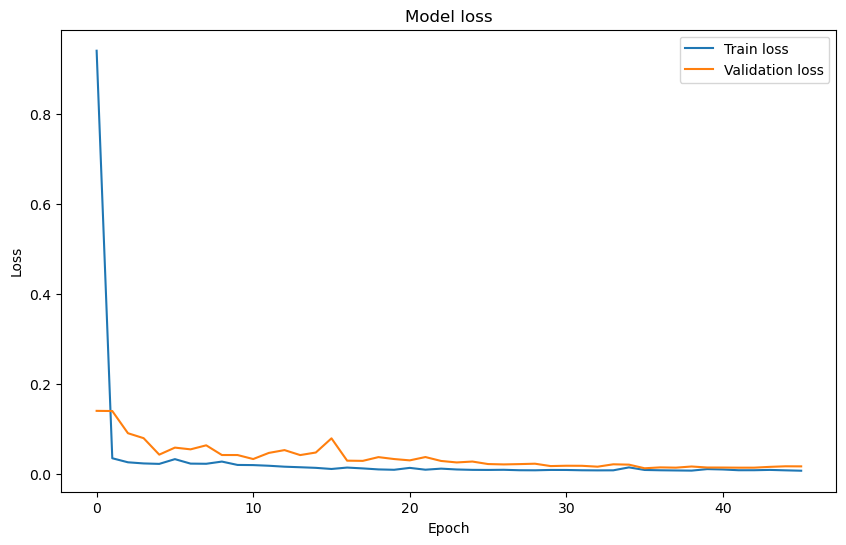

In [40]:
# Check the shape of y_train and y_test
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# Ensure y_train and y_test have the shape (num_samples, 9)
# If they have shape (num_samples,) or (num_samples, 1), you need to reshape them
if y_train.ndim == 1 or y_train.shape[1] == 1:
    y_train = y_train.reshape(-1, y_shape)
if y_test.ndim == 1 or y_test.shape[1] == 1:
    y_test = y_test.reshape(-1, y_shape)

# Train the model with early stopping
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_train_pred = transformation_pipeline.inverse_transform(y_train_pred.reshape(-1, y_shape))
y_test_pred = transformation_pipeline.inverse_transform(y_test_pred.reshape(-1, y_shape))
y_train_actual = transformation_pipeline.inverse_transform(y_train.reshape(-1, y_shape))
y_test_actual = transformation_pipeline.inverse_transform(y_test.reshape(-1, y_shape))

# Check for infinite values and replace them with NaN
y_train_pred = np.where(np.isinf(y_train_pred), np.nan, y_train_pred)
y_test_pred = np.where(np.isinf(y_test_pred), np.nan, y_test_pred)
y_train_actual = np.where(np.isinf(y_train_actual), np.nan, y_train_actual)
y_test_actual = np.where(np.isinf(y_test_actual), np.nan, y_test_actual)

# Handle NaN values (e.g., by filling them with the mean of the array)
y_train_pred = np.nan_to_num(y_train_pred, nan=np.nanmean(y_train_pred))
y_test_pred = np.nan_to_num(y_test_pred, nan=np.nanmean(y_test_pred))
y_train_actual = np.nan_to_num(y_train_actual, nan=np.nanmean(y_train_actual))
y_test_actual = np.nan_to_num(y_test_actual, nan=np.nanmean(y_test_actual))

# Round the predictions and actual values to 6 decimal places
y_train_pred = np.round(y_train_pred, 6)
y_test_pred = np.round(y_test_pred, 6)
y_train_actual = np.round(y_train_actual, 6)
y_test_actual = np.round(y_test_actual, 6)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Training MAE: 35.59
Testing MAE: 43.21

Training MedAE: 27.49
Testing MedAE: 31.15

Training RMSE: 55.98
Testing RMSE: 55.98

Training MAPE: 14.48%
Testing MAPE: 14.48%


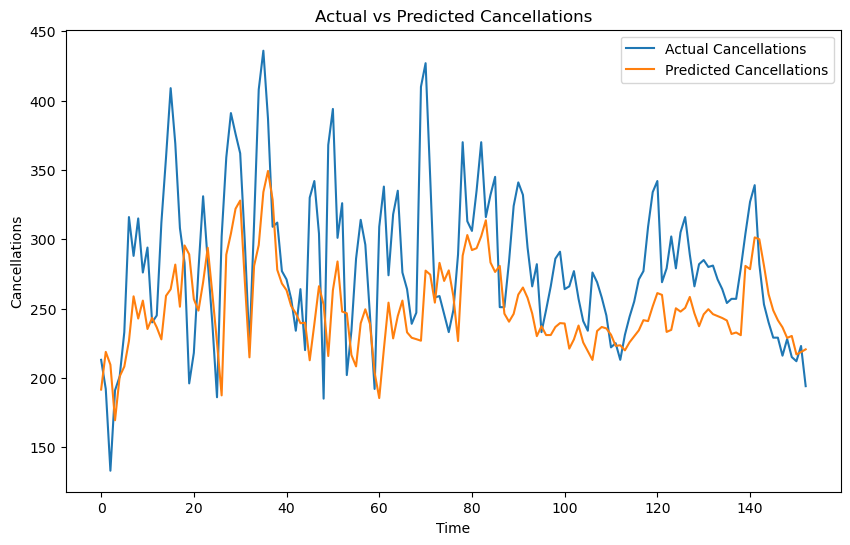

In [42]:
# Calculate performance metrics
train_mae = mean_absolute_error(y_train_actual[:, 0], y_train_pred[:, 0])
test_mae = mean_absolute_error(y_test_actual[:, 0], y_test_pred[:, 0])
train_medae = median_absolute_error(y_train_actual[:, 0], y_train_pred[:, 0])
test_medae = median_absolute_error(y_test_actual[:, 0], y_test_pred[:, 0])
train_mse = mean_squared_error(y_test_actual[:, 0], y_test_pred[:, 0])
test_mse = mean_squared_error(y_test_actual[:, 0], y_test_pred[:, 0])
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mape = mean_absolute_percentage_error(y_test_actual[:, 0], y_test_pred[:, 0])
test_mape = mean_absolute_percentage_error(y_test_actual[:, 0], y_test_pred[:, 0])

print(f'Training MAE: {train_mae:.2f}')
print(f'Testing MAE: {test_mae:.2f}\n')
print(f'Training MedAE: {train_medae:.2f}')
print(f'Testing MedAE: {test_medae:.2f}\n')
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Testing RMSE: {test_rmse:.2f}\n')
print(f'Training MAPE: {train_mape*100:.2f}%')
print(f'Testing MAPE: {test_mape *100:.2f}%')


# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual[:, 0], label='Actual Cancellations')
plt.plot(y_test_pred[:, 0], label='Predicted Cancellations')
plt.title('Actual vs Predicted Cancellations')
plt.xlabel('Time')
plt.ylabel('Cancellations')
plt.legend()
plt.show()

Training MAE: 26.89
Testing MAE: 13.57

Training MedAE: 19.13
Testing MedAE: 8.69

Training RMSE: 18.87
Testing RMSE: 18.87

Training MAPE: 3.61%
Testing MAPE: 3.61%



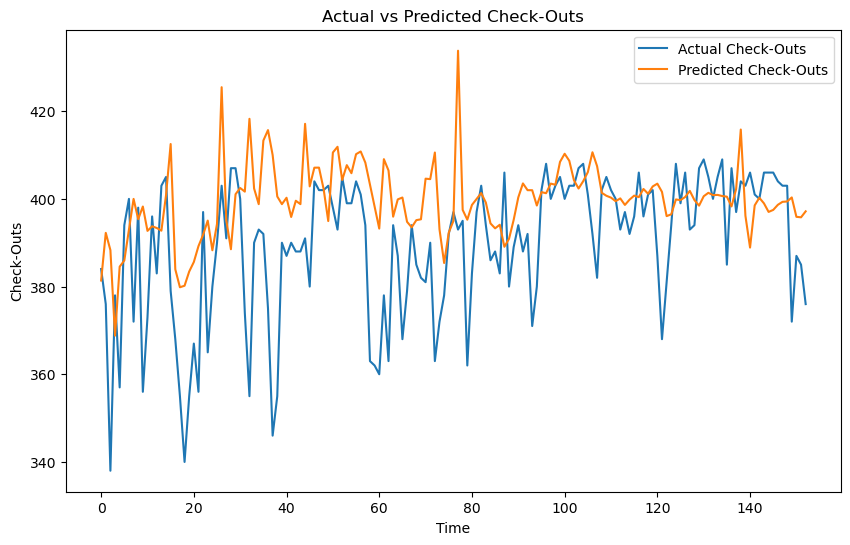

In [43]:
# Calculate performance metrics
train_mae = mean_absolute_error(y_train_actual[:, 1], y_train_pred[:, 1])
test_mae = mean_absolute_error(y_test_actual[:, 1], y_test_pred[:, 1])
train_medae = median_absolute_error(y_train_actual[:, 1], y_train_pred[:, 1])
test_medae = median_absolute_error(y_test_actual[:, 1], y_test_pred[:, 1])
train_mse = mean_squared_error(y_test_actual[:, 1], y_test_pred[:, 1])
test_mse = mean_squared_error(y_test_actual[:, 1], y_test_pred[:, 1])
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mape = mean_absolute_percentage_error(y_test_actual[:, 1], y_test_pred[:, 1])
test_mape = mean_absolute_percentage_error(y_test_actual[:, 1], y_test_pred[:, 1])

print(f'Training MAE: {train_mae:.2f}')
print(f'Testing MAE: {test_mae:.2f}\n')
print(f'Training MedAE: {train_medae:.2f}')
print(f'Testing MedAE: {test_medae:.2f}\n')
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Testing RMSE: {test_rmse:.2f}\n')
print(f'Training MAPE: {train_mape*100:.2f}%')
print(f'Testing MAPE: {test_mape *100:.2f}%\n')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual[:, 1], label='Actual Check-Outs')
plt.plot(y_test_pred[:, 1], label='Predicted Check-Outs')
plt.title('Actual vs Predicted Check-Outs')
plt.xlabel('Time')
plt.ylabel('Check-Outs')
plt.legend()
plt.show()

In [38]:
# Make predictions
forecast = model.predict(X_test)

# Inverse transform the forecasted values
forecast = transformation_pipeline.inverse_transform(forecast)

# Print the forecasted values
print(forecast)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[ 2.18963074e+02  3.64320679e+02  2.67125107e-02 -1.08510097e-02
  -2.31311582e-02]
 [ 2.35805359e+02  3.74904114e+02  3.33300233e-02 -2.11553238e-02
  -1.48232430e-02]
 [ 2.29189957e+02  3.67186920e+02  5.35880923e-02 -1.30066285e-02
  -2.05686092e-02]
 [ 2.18384155e+02  3.63327545e+02  4.68703099e-02 -1.28237652e-02
  -2.29912139e-02]
 [ 2.29875122e+02  3.63986664e+02  4.38476726e-02  3.61936633e-03
  -2.42732540e-02]
 [ 2.15978500e+02  3.59577240e+02  4.69571128e-02  3.17427423e-03
  -1.84604749e-02]
 [ 2.43533005e+02  3.70757416e+02  4.52854373e-02  1.63803399e-02
  -2.34734900e-02]
 [ 2.65921478e+02  3.78502411e+02  3.92681174e-02  3.73711325e-02
  -2.32310146e-02]
 [ 2.75415436e+02  3.79365784e+02  6.24092482e-02  6.15518354e-02
  -2.01595947e-02]
 [ 2.75428986e+02  3.79743256e+02  5.35160191e-02  6.58531487e-02
  -1.46555956e-02]
 [ 2.72415497e+02  3.79269623e+02  6.12339601e-02  7.35356063e-02
  -1.87695473e-02]
 [ 2.77834839e+02  3.834234